In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import tensorflow as tf
import tensorflow.keras as keras
import os
from keras.models import Sequential,Model
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
#from keras.utils import plot_model
import pydot_ng as pydot
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
#!pip install plot_model
data=pd.read_csv("/content/test_scores.csv")
data.head(10)

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0
5,ANKYI,Urban,Non-public,6OL,Standard,20.0,7YZO8,Female,Does not qualify,66.0,74.0
6,ANKYI,Urban,Non-public,6OL,Standard,20.0,9KMZD,Male,Does not qualify,63.0,75.0
7,ANKYI,Urban,Non-public,6OL,Standard,20.0,9USQK,Female,Does not qualify,63.0,72.0
8,ANKYI,Urban,Non-public,6OL,Standard,20.0,CS5QP,Male,Does not qualify,64.0,77.0
9,ANKYI,Urban,Non-public,6OL,Standard,20.0,D6HT8,Female,Does not qualify,61.0,72.0


In [3]:
header = ["school", "school_setting", 'school_type', 'classroom', 'teaching_method', 'n_student', 
          'student_id', 'gender', 'lunch', 'pretest', 'posttest']

In [5]:
train_data=data.copy()

In [6]:
train_data.select_dtypes(['object']).columns

Index(['school', 'school_setting', 'school_type', 'classroom',
       'teaching_method', 'student_id', 'gender', 'lunch'],
      dtype='object')

In [7]:
le_dict= {}
for col in train_data.select_dtypes(['object']):
  le = LabelEncoder()
  train_data[col] = le.fit_transform(train_data[col])
  #test_data[col] = le.transform(test_data[col])
  #Save a mapping of categorical columns values and its transforamtion - needed 
  #later on for mapping purposes
  le_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [8]:

# Viewing the data after label encoding
train_data.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,0,2,0,22,1,20.0,148,0,0,62.0,72.0
1,0,2,0,22,1,20.0,207,0,0,66.0,79.0
2,0,2,0,22,1,20.0,227,1,0,64.0,76.0
3,0,2,0,22,1,20.0,297,0,0,61.0,77.0
4,0,2,0,22,1,20.0,413,1,0,64.0,76.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['posttest'], axis = 1), train_data['posttest'], random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1599, 10), (534, 10), (1599,), (534,))

In [10]:
from sklearn.ensemble import RandomForestRegressor
randomforest=RandomForestRegressor()
randomforest.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [11]:
randomforest_prediction=randomforest.predict(X_test)

In [12]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, randomforest_prediction))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, randomforest_prediction))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, randomforest_prediction)))
print('R^2:', metrics.r2_score(y_test, randomforest_prediction))

Mean Absolute Error (MAE): 2.5434831460674157
Mean Squared Error (MSE): 10.625751310861423
Root Mean Squared Error (RMSE): 3.2597164463893824
R^2: 0.9455807402309646


In [13]:
categorical_columns = ['school','school_setting','school_type','classroom','teaching_method','gender','lunch']
input_train_list = []
input_test_list = []
for c in categorical_columns:
  input_train_list.append(X_train[c].values)
  input_test_list.append(X_test[c].values)

In [16]:
# input models will capture all the input list
input_models=[]
# output embeddings will capture all the output embeddings
output_embeddings=[]
for c in categorical_columns:
  cat_emb_name= c+'_Embedding'
  #Identifying the number of unique values in the category
  no_of_unique_cat  = X_train[c].nunique()
  # Defining the output embedding size - currently taken it to be 10 for 
  # simplicity, Jeremy Howard Fast AI course gives empirical formula for this to
  # be int(min(np.ceil(no_of_unique_cat/2, 50))) i.e choosing the minimum of
  # 50 or half the number of categories in the column
  embedding_size = 50
  input_model = Input(shape=(1,),name = c+'_Input')
  output_model = Embedding(no_of_unique_cat, embedding_size,name=cat_emb_name)(input_model)
  output_model = Reshape(target_shape=(embedding_size,))(output_model)   

  input_models.append(input_model)
  output_embeddings.append(output_model) 

output = Concatenate()(output_embeddings)
output = Dense(512, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(256, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mape'])

In [19]:
history  =  model.fit(input_train_list, y_train, validation_data=(input_test_list, y_test) , epochs =  500 , batch_size = 32, verbose= 2)

Epoch 1/500
50/50 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4360 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 2/500
50/50 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4360 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 3/500
50/50 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4360 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 4/500
50/50 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4361 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 5/500
50/50 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4361 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 6/500
50/50 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4361 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 7/500
50/50 - 0s - loss: 4550.3447 - mse: 4550.3447 - mape: 98.4361 - val_loss: 4609.0430 - val_mse: 4609.0430 - val_mape: 98.4477
Epoch 8/500
50/50 - 0s - loss: 4550.3447 

Text(0.5, 1.0, 'loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

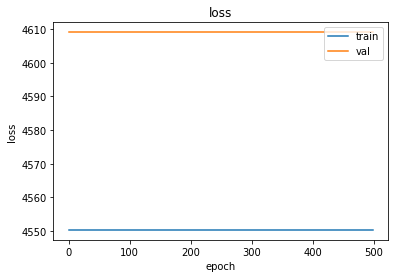

In [20]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [21]:
model.get_layer('school_Embedding').get_weights()[0].shape
# Below are the learned embedding for each unique category in the workclass columns
model.get_layer('school_setting_Embedding').get_weights()[0].shape
model.get_layer('school_type_Embedding').get_weights()[0].shape
model.get_layer('classroom_Embedding').get_weights()[0].shape
model.get_layer('teaching_method_Embedding').get_weights()[0].shape
model.get_layer('gender_Embedding').get_weights()[0].shape
model.get_layer('lunch_Embedding').get_weights()[0].shape

# The shape is (7,10) meaning 7 unique values each described by 10 values 
# (embedding size)

(23, 50)

(3, 50)

(2, 50)

(97, 50)

(2, 50)

(2, 50)

(2, 50)

In [22]:
# We saved the label encoder for extracting the embeddings
le_dict['school'].items()

dict_items([('ANKYI', 0), ('CCAAW', 1), ('CIMBB', 2), ('CUQAM', 3), ('DNQDD', 4), ('FBUMG', 5), ('GJJHK', 6), ('GOKXL', 7), ('GOOBU', 8), ('IDGFP', 9), ('KFZMY', 10), ('KZKKE', 11), ('LAYPA', 12), ('OJOBU', 13), ('QOQTS', 14), ('UAGPU', 15), ('UKPGS', 16), ('UUUQX', 17), ('VHDHF', 18), ('VKWQH', 19), ('VVTVA', 20), ('ZMNYA', 21), ('ZOWMK', 22)])

In [23]:
# Need to extract embedding based on the label encoding
school_embeddings = {idx:model.get_layer('school_Embedding').get_weights()[0][idx] for w, idx in le_dict['school'].items()}
school_setting_embeddings = {idx:model.get_layer('school_setting_Embedding').get_weights()[0][idx] for w, idx in le_dict['school_setting'].items()}
# Need to extract embedding based on the label encoding
classroom_embeddings = {idx:model.get_layer('classroom_Embedding').get_weights()[0][idx] for w, idx in le_dict['classroom'].items()}
school_type_embeddings = {idx:model.get_layer('school_type_Embedding').get_weights()[0][idx] for w, idx in le_dict['school_type'].items()}
# Need to extract embedding based on the label encoding
teaching_method_embeddings = {idx:model.get_layer('teaching_method_Embedding').get_weights()[0][idx] for w, idx in le_dict['teaching_method'].items()}
gender_embeddings = {idx:model.get_layer('gender_Embedding').get_weights()[0][idx] for w, idx in le_dict['gender'].items()}
lunch_embeddings = {idx:model.get_layer('lunch_Embedding').get_weights()[0][idx] for w, idx in le_dict['lunch'].items()}

In [25]:
school_embeddings_df = pd.DataFrame(school_embeddings)
school_embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,-0.000497,0.027194,-0.018427,0.049787,0.036018,-0.014997,0.045437,0.062560,0.011923,-0.038824,0.003050,0.068574,-0.004212,0.065088,0.038472,0.045491,0.058696,0.050410,-0.010622,0.023561,0.049232,-0.027362,0.000844
1,-0.042398,-0.007850,-0.056831,-0.004911,-0.015282,-0.067549,-0.038734,-0.000820,-0.038418,-0.045172,0.024282,-0.053668,0.026028,-0.009400,-0.046384,-0.018042,0.024043,-0.046672,-0.011188,-0.016497,-0.062876,-0.021242,-0.023311
2,-0.009798,0.029117,-0.011015,0.037588,0.063251,-0.027585,0.049255,0.042459,-0.003358,-0.013130,0.064208,0.017456,0.023763,0.011059,0.064094,-0.016423,0.040650,0.037126,-0.013359,0.004349,0.052870,0.001909,-0.040424
3,0.009945,-0.041636,0.049025,-0.030654,0.041417,-0.022967,-0.011357,0.027505,-0.044512,-0.038427,-0.045114,0.030851,0.034676,-0.029297,0.003554,0.035982,-0.010845,0.011724,-0.025688,0.012118,-0.025253,0.005180,-0.029652
4,-0.012425,0.024351,0.044116,0.054406,-0.022758,0.058573,0.050931,0.019575,0.043119,-0.024515,0.017647,0.054656,0.024534,0.044062,-0.011991,-0.020543,0.063045,0.024995,-0.013155,0.007364,0.009189,0.063162,0.029042


In [26]:
school_setting_embeddings_df = pd.DataFrame(school_setting_embeddings)
classroom_embeddings_df = pd.DataFrame(classroom_embeddings)
teaching_method_embeddings_df = pd.DataFrame(teaching_method_embeddings)
gender_embeddings_df = pd.DataFrame(gender_embeddings)
lunch_embeddings_df = pd.DataFrame(lunch_embeddings)
school_type_embeddings_df = pd.DataFrame(school_type_embeddings)

In [27]:
school_embeddings_df = school_embeddings_df.T.reset_index()
school_embeddings_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.029260,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.000900,-0.030239,-0.048890,-0.009858,0.048960,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.028020,-0.010103,-0.052410,-0.039696,-0.038833,-0.027306,-0.065645,-0.045716,0.051282,0.030660,0.049038,-0.009543,-0.035342,-0.036229,-0.047657
1,1,0.027194,-0.007850,0.029117,-0.041636,0.024351,0.061880,-0.014522,0.034422,0.059873,-0.049121,-0.018828,-0.065104,-0.027205,-0.011898,-0.006807,-0.035575,-0.015839,-0.035535,-0.035400,-0.029558,0.058267,-0.057181,-0.046122,-0.030572,-0.028359,0.030417,-0.015913,0.011200,0.035142,-0.049709,-0.023123,0.051581,0.009940,-0.008854,-0.027326,-0.019139,-0.051988,0.011932,-0.035705,-0.041408,0.044356,-0.030470,-0.011575,0.059578,0.019687,-0.008773,-0.031586,-0.028483,0.059404,0.034167
2,2,-0.018427,-0.056831,-0.011015,0.049025,0.044116,0.047810,-0.031235,-0.012951,-0.022486,-0.066102,-0.046417,-0.064255,-0.005501,-0.047981,0.044574,0.045978,-0.020227,0.002228,-0.013975,0.046427,0.036876,-0.051679,-0.016059,0.012360,-0.046878,-0.030559,-0.034583,0.027270,0.023105,-0.032011,-0.016908,-0.013272,-0.018812,0.014088,0.015645,0.042347,-0.041430,0.011683,0.024585,-0.058479,0.038801,-0.021717,-0.027532,0.041631,0.008095,-0.036007,0.043430,0.029771,0.047853,0.026315
3,3,0.049787,-0.004911,0.037588,-0.030654,0.054406,0.019671,0.020347,0.038452,0.018325,0.039843,-0.047673,-0.013145,-0.016594,-0.021073,0.022580,0.021638,0.017891,0.032607,0.033855,0.043684,-0.051799,0.029321,-0.056246,-0.005356,0.027955,-0.011399,0.015713,-0.060708,0.006603,-0.025456,0.054718,-0.036621,0.013164,-0.018597,-0.004882,0.055784,0.025731,-0.038499,-0.045675,-0.056316,0.026817,-0.054214,0.038548,0.055969,-0.048984,0.023906,0.027848,0.058776,0.051482,-0.020630
4,4,0.036018,-0.015282,0.063251,0.041417,-0.022758,-0.006156,-0.029205,-0.030636,0.047739,-0.054577,-0.062273,0.018523,-0.039367,-0.028430,-0.009330,0.039154,0.009405,0.024118,-0.029397,0.039627,-0.028956,0.009067,-0.029018,0.056666,0.006423,0.018784,-0.036409,-0.062163,0.019766,-0.042888,0.051528,0.046015,0.015562,-0.044989,0.043947,-0.003080,0.047466,-0.033305,-0.063472,-0.061511,-0.017997,0.010508,-0.007673,0.012578,0.037309,0.000332,0.053082,0.024386,-0.004335,-0.020044


In [42]:
school_embeddings_df = school_embeddings_df.add_suffix('_school')
school_embeddings_df.head()

,index_school,0_school,1_school,2_school,3_school,4_school,5_school,6_school,7_school,8_school,9_school,10_school,11_school,12_school,13_school,14_school,15_school,16_school,17_school,18_school,19_school,20_school,21_school,22_school,23_school,24_school,25_school,26_school,27_school,28_school,29_school,30_school,31_school,32_school,33_school,34_school,35_school,36_school,37_school,38_school,39_school,40_school,41_school,42_school,43_school,44_school,45_school,46_school,47_school,48_school,49_school
0,0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.029260,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.000900,-0.030239,-0.048890,-0.009858,0.048960,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.028020,-0.010103,-0.052410,-0.039696,-0.038833,-0.027306,-0.065645,-0.045716,0.051282,0.030660,0.049038,-0.009543,-0.035342,-0.036229,-0.047657
1,1,0.027194,-0.007850,0.029117,-0.041636,0.024351,0.061880,-0.014522,0.034422,0.059873,-0.049121,-0.018828,-0.065104,-0.027205,-0.011898,-0.006807,-0.035575,-0.015839,-0.035535,-0.035400,-0.029558,0.058267,-0.057181,-0.046122,-0.030572,-0.028359,0.030417,-0.015913,0.011200,0.035142,-0.049709,-0.023123,0.051581,0.009940,-0.008854,-0.027326,-0.019139,-0.051988,0.011932,-0.035705,-0.041408,0.044356,-0.030470,-0.011575,0.059578,0.019687,-0.008773,-0.031586,-0.028483,0.059404,0.034167
2,2,-0.018427,-0.056831,-0.011015,0.049025,0.044116,0.047810,-0.031235,-0.012951,-0.022486,-0.066102,-0.046417,-0.064255,-0.005501,-0.047981,0.044574,0.045978,-0.020227,0.002228,-0.013975,0.046427,0.036876,-0.051679,-0.016059,0.012360,-0.046878,-0.030559,-0.034583,0.027270,0.023105,-0.032011,-0.016908,-0.013272,-0.018812,0.014088,0.015645,0.042347,-0.041430,0.011683,0.024585,-0.058479,0.038801,-0.021717,-0.027532,0.041631,0.008095,-0.036007,0.043430,0.029771,0.047853,0.026315
3,3,0.049787,-0.004911,0.037588,-0.030654,0.054406,0.019671,0.020347,0.038452,0.018325,0.039843,-0.047673,-0.013145,-0.016594,-0.021073,0.022580,0.021638,0.017891,0.032607,0.033855,0.043684,-0.051799,0.029321,-0.056246,-0.005356,0.027955,-0.011399,0.015713,-0.060708,0.006603,-0.025456,0.054718,-0.036621,0.013164,-0.018597,-0.004882,0.055784,0.025731,-0.038499,-0.045675,-0.056316,0.026817,-0.054214,0.038548,0.055969,-0.048984,0.023906,0.027848,0.058776,0.051482,-0.020630
4,4,0.036018,-0.015282,0.063251,0.041417,-0.022758,-0.006156,-0.029205,-0.030636,0.047739,-0.054577,-0.062273,0.018523,-0.039367,-0.028430,-0.009330,0.039154,0.009405,0.024118,-0.029397,0.039627,-0.028956,0.009067,-0.029018,0.056666,0.006423,0.018784,-0.036409,-0.062163,0.019766,-0.042888,0.051528,0.046015,0.015562,-0.044989,0.043947,-0.003080,0.047466,-0.033305,-0.063472,-0.061511,-0.017997,0.010508,-0.007673,0.012578,0.037309,0.000332,0.053082,0.024386,-0.004335,-0.020044


In [43]:
school_setting_embeddings_df = school_setting_embeddings_df.T.reset_index()
school_setting_embeddings_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,-0.005475,0.040722,-0.022542,0.009648,-0.030128,-0.017951,0.004588,-0.016281,0.008650,-0.015447,0.064265,0.038110,0.070732,-0.052372,0.003749,0.054670,-0.042500,-0.012765,0.037814,-0.007140,0.043599,-0.030340,0.036501,0.067452,-0.034898,-0.075655,-0.018176,0.054632,-0.021482,0.012166,0.001356,-0.040636,0.018627,-0.009200,-0.061935,0.020131,-0.031585,0.039554,-0.063303,0.050701,-0.019988,0.050208,-0.020513,0.014228,-0.013256,-0.020423,0.052601,0.047028,0.004639,-0.010274
1,1,-0.045471,0.048702,-0.072218,0.034460,-0.017350,0.008364,-0.047345,0.006714,-0.052126,0.046032,0.031119,0.069923,0.017660,-0.060350,-0.028858,0.064990,-0.047910,-0.032967,0.044289,0.000603,0.031373,-0.024473,0.028967,0.034477,0.006668,-0.058941,0.048202,0.067912,0.037981,0.001037,-0.057234,-0.066875,-0.051931,-0.057032,0.019790,0.071855,-0.030497,0.007445,-0.027191,-0.011209,0.043118,0.066298,0.016820,0.057548,-0.055940,0.066903,0.016752,0.053654,0.057496,0.043125
2,2,-0.038392,-0.025345,-0.035171,-0.045465,-0.062167,0.046018,-0.044496,-0.057423,-0.019485,0.036930,0.059428,-0.011866,0.016388,-0.016018,0.047594,0.019573,-0.040158,-0.029829,0.012251,-0.053216,0.053366,-0.062409,0.021138,-0.043292,-0.049198,0.023212,0.049061,0.022976,0.056065,0.035688,-0.035750,-0.048165,0.046502,-0.047619,-0.064604,0.012305,-0.041273,0.025382,-0.047328,0.044050,-0.058863,0.047989,-0.071176,0.011984,-0.070614,0.053222,0.017885,-0.014208,-0.022756,0.051435


In [44]:
school_setting_embeddings_df = school_setting_embeddings_df.add_suffix('_school_setting')
school_setting_embeddings_df.head()

,index_school_setting,0_school_setting,1_school_setting,2_school_setting,3_school_setting,4_school_setting,5_school_setting,6_school_setting,7_school_setting,8_school_setting,9_school_setting,10_school_setting,11_school_setting,12_school_setting,13_school_setting,14_school_setting,15_school_setting,16_school_setting,17_school_setting,18_school_setting,19_school_setting,20_school_setting,21_school_setting,22_school_setting,23_school_setting,24_school_setting,25_school_setting,26_school_setting,27_school_setting,28_school_setting,29_school_setting,30_school_setting,31_school_setting,32_school_setting,33_school_setting,34_school_setting,35_school_setting,36_school_setting,37_school_setting,38_school_setting,39_school_setting,40_school_setting,41_school_setting,42_school_setting,43_school_setting,44_school_setting,45_school_setting,46_school_setting,47_school_setting,48_school_setting,49_school_setting
0,0,-0.005475,0.040722,-0.022542,0.009648,-0.030128,-0.017951,0.004588,-0.016281,0.008650,-0.015447,0.064265,0.038110,0.070732,-0.052372,0.003749,0.054670,-0.042500,-0.012765,0.037814,-0.007140,0.043599,-0.030340,0.036501,0.067452,-0.034898,-0.075655,-0.018176,0.054632,-0.021482,0.012166,0.001356,-0.040636,0.018627,-0.009200,-0.061935,0.020131,-0.031585,0.039554,-0.063303,0.050701,-0.019988,0.050208,-0.020513,0.014228,-0.013256,-0.020423,0.052601,0.047028,0.004639,-0.010274
1,1,-0.045471,0.048702,-0.072218,0.034460,-0.017350,0.008364,-0.047345,0.006714,-0.052126,0.046032,0.031119,0.069923,0.017660,-0.060350,-0.028858,0.064990,-0.047910,-0.032967,0.044289,0.000603,0.031373,-0.024473,0.028967,0.034477,0.006668,-0.058941,0.048202,0.067912,0.037981,0.001037,-0.057234,-0.066875,-0.051931,-0.057032,0.019790,0.071855,-0.030497,0.007445,-0.027191,-0.011209,0.043118,0.066298,0.016820,0.057548,-0.055940,0.066903,0.016752,0.053654,0.057496,0.043125
2,2,-0.038392,-0.025345,-0.035171,-0.045465,-0.062167,0.046018,-0.044496,-0.057423,-0.019485,0.036930,0.059428,-0.011866,0.016388,-0.016018,0.047594,0.019573,-0.040158,-0.029829,0.012251,-0.053216,0.053366,-0.062409,0.021138,-0.043292,-0.049198,0.023212,0.049061,0.022976,0.056065,0.035688,-0.035750,-0.048165,0.046502,-0.047619,-0.064604,0.012305,-0.041273,0.025382,-0.047328,0.044050,-0.058863,0.047989,-0.071176,0.011984,-0.070614,0.053222,0.017885,-0.014208,-0.022756,0.051435


In [45]:
classroom_embeddings_df = classroom_embeddings_df.T.reset_index()
classroom_embeddings_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,-0.024037,-0.047090,0.001290,0.052577,-0.024935,-0.044534,0.048633,-0.043439,-0.034333,-0.045774,-0.058129,-0.022542,-0.011091,-0.043304,-0.032499,0.023542,0.020221,0.016712,-0.034213,-0.053299,0.047447,-0.007941,0.056108,0.033075,0.020192,0.033025,0.033047,-0.016678,0.035443,-0.028758,-0.016198,0.047857,0.025070,0.007588,-0.006441,0.013090,0.015507,0.032033,0.025821,-0.014491,-0.022034,-0.010528,0.032272,0.016009,0.046397,0.037488,0.021551,-0.048809,0.029700,-0.009979
1,1,-0.008366,-0.021591,-0.052120,-0.006688,0.050370,0.022677,-0.004843,0.028462,0.005857,0.034991,-0.006841,0.031769,0.044252,-0.009326,0.001742,-0.031088,0.041245,-0.037529,0.033198,-0.008803,0.011009,0.007281,-0.003167,0.032471,-0.022515,0.011777,0.000400,-0.009718,-0.018154,-0.001410,0.020733,0.018050,-0.024500,0.030229,0.035151,0.018890,0.047635,-0.027418,-0.017458,0.034328,0.000706,0.054507,-0.024887,-0.059761,-0.017720,-0.004173,-0.014321,0.045058,-0.014138,-0.018008
2,2,-0.014608,-0.063292,-0.025502,0.029619,-0.003522,-0.030715,-0.022635,-0.011943,-0.021747,-0.007260,-0.038244,0.040919,-0.020631,-0.000553,-0.051156,0.042024,0.025233,0.021057,-0.003403,-0.015105,0.047016,0.001299,0.050140,-0.058342,0.056401,0.035288,-0.033842,0.024660,-0.043391,-0.022873,-0.054683,0.018926,-0.018271,0.011464,0.023651,-0.051853,-0.032588,0.030822,0.032955,-0.022541,-0.038676,0.037360,0.049787,0.004894,-0.020248,-0.002306,-0.035322,-0.040591,0.011213,0.022181
3,3,0.010286,-0.016513,-0.024059,0.030166,-0.009888,0.011252,-0.035818,-0.001048,0.021151,-0.051406,-0.017085,0.003689,0.022030,-0.018392,-0.022850,0.050712,-0.028051,0.019004,-0.008557,-0.010862,-0.011290,0.024604,0.037139,0.014375,-0.003463,-0.001950,0.047630,-0.024551,-0.033323,-0.012623,-0.042287,-0.011611,-0.033723,-0.009688,0.014979,-0.060124,-0.058456,-0.020253,-0.003640,0.061510,-0.011085,-0.023146,0.025518,-0.027318,0.023864,0.025477,-0.021454,-0.044744,0.048328,-0.022913
4,4,0.032465,-0.002597,-0.024328,-0.032525,-0.035871,0.038482,-0.042237,0.032004,0.008712,-0.016318,0.009202,-0.045409,0.000021,0.044309,-0.006508,0.051574,0.058005,0.014125,0.022440,0.040638,-0.035064,0.036190,0.052277,-0.023747,0.060297,-0.004282,0.011593,0.000154,0.036566,0.042525,0.031627,-0.011561,-0.006630,0.030299,0.050137,-0.032400,-0.020519,0.016561,-0.012781,0.040817,-0.022499,-0.033653,0.046196,-0.043259,-0.012521,0.008747,0.048655,-0.008777,0.011550,-0.059564


In [46]:
classroom_embeddings_df = classroom_embeddings_df.add_suffix('_classroom')
classroom_embeddings_df.head()

,index_classroom,0_classroom,1_classroom,2_classroom,3_classroom,4_classroom,5_classroom,6_classroom,7_classroom,8_classroom,9_classroom,10_classroom,11_classroom,12_classroom,13_classroom,14_classroom,15_classroom,16_classroom,17_classroom,18_classroom,19_classroom,20_classroom,21_classroom,22_classroom,23_classroom,24_classroom,25_classroom,26_classroom,27_classroom,28_classroom,29_classroom,30_classroom,31_classroom,32_classroom,33_classroom,34_classroom,35_classroom,36_classroom,37_classroom,38_classroom,39_classroom,40_classroom,41_classroom,42_classroom,43_classroom,44_classroom,45_classroom,46_classroom,47_classroom,48_classroom,49_classroom
0,0,-0.024037,-0.047090,0.001290,0.052577,-0.024935,-0.044534,0.048633,-0.043439,-0.034333,-0.045774,-0.058129,-0.022542,-0.011091,-0.043304,-0.032499,0.023542,0.020221,0.016712,-0.034213,-0.053299,0.047447,-0.007941,0.056108,0.033075,0.020192,0.033025,0.033047,-0.016678,0.035443,-0.028758,-0.016198,0.047857,0.025070,0.007588,-0.006441,0.013090,0.015507,0.032033,0.025821,-0.014491,-0.022034,-0.010528,0.032272,0.016009,0.046397,0.037488,0.021551,-0.048809,0.029700,-0.009979
1,1,-0.008366,-0.021591,-0.052120,-0.006688,0.050370,0.022677,-0.004843,0.028462,0.005857,0.034991,-0.006841,0.031769,0.044252,-0.009326,0.001742,-0.031088,0.041245,-0.037529,0.033198,-0.008803,0.011009,0.007281,-0.003167,0.032471,-0.022515,0.011777,0.000400,-0.009718,-0.018154,-0.001410,0.020733,0.018050,-0.024500,0.030229,0.035151,0.018890,0.047635,-0.027418,-0.017458,0.034328,0.000706,0.054507,-0.024887,-0.059761,-0.017720,-0.004173,-0.014321,0.045058,-0.014138,-0.018008
2,2,-0.014608,-0.063292,-0.025502,0.029619,-0.003522,-0.030715,-0.022635,-0.011943,-0.021747,-0.007260,-0.038244,0.040919,-0.020631,-0.000553,-0.051156,0.042024,0.025233,0.021057,-0.003403,-0.015105,0.047016,0.001299,0.050140,-0.058342,0.056401,0.035288,-0.033842,0.024660,-0.043391,-0.022873,-0.054683,0.018926,-0.018271,0.011464,0.023651,-0.051853,-0.032588,0.030822,0.032955,-0.022541,-0.038676,0.037360,0.049787,0.004894,-0.020248,-0.002306,-0.035322,-0.040591,0.011213,0.022181
3,3,0.010286,-0.016513,-0.024059,0.030166,-0.009888,0.011252,-0.035818,-0.001048,0.021151,-0.051406,-0.017085,0.003689,0.022030,-0.018392,-0.022850,0.050712,-0.028051,0.019004,-0.008557,-0.010862,-0.011290,0.024604,0.037139,0.014375,-0.003463,-0.001950,0.047630,-0.024551,-0.033323,-0.012623,-0.042287,-0.011611,-0.033723,-0.009688,0.014979,-0.060124,-0.058456,-0.020253,-0.003640,0.061510,-0.011085,-0.023146,0.025518,-0.027318,0.023864,0.025477,-0.021454,-0.044744,0.048328,-0.022913
4,4,0.032465,-0.002597,-0.024328,-0.032525,-0.035871,0.038482,-0.042237,0.032004,0.008712,-0.016318,0.009202,-0.045409,0.000021,0.044309,-0.006508,0.051574,0.058005,0.014125,0.022440,0.040638,-0.035064,0.036190,0.052277,-0.023747,0.060297,-0.004282,0.011593,0.000154,0.036566,0.042525,0.031627,-0.011561,-0.006630,0.030299,0.050137,-0.032400,-0.020519,0.016561,-0.012781,0.040817,-0.022499,-0.033653,0.046196,-0.043259,-0.012521,0.008747,0.048655,-0.008777,0.011550,-0.059564


In [47]:
teaching_method_embeddings_df = teaching_method_embeddings_df.T.reset_index()
teaching_method_embeddings_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,-0.062871,-0.040713,-0.042663,-0.059508,-0.002330,0.004618,-0.018145,0.018141,0.050108,-0.021149,0.036378,0.009669,0.019254,0.052045,0.039795,-0.036480,-0.010781,-0.045791,0.038540,-0.023495,0.071669,0.037843,0.031505,0.006691,0.067681,0.061209,-0.032874,0.027068,-0.028148,0.031341,-0.001435,-0.024884,0.060753,0.070289,-0.070411,-0.054081,-0.017358,0.037193,-0.007441,0.024595,0.061182,0.045690,0.063153,-0.039313,0.065170,0.032249,0.028695,0.010130,0.041335,0.037927
1,1,-0.023800,0.065872,-0.001957,-0.037060,0.042566,-0.040135,-0.051749,0.026306,0.022846,-0.033986,0.045651,0.057489,0.055832,0.017700,0.046001,-0.030768,0.040599,-0.050098,-0.013859,-0.061120,0.057997,0.057267,0.019837,0.030042,0.052822,0.008134,-0.070908,0.055878,-0.029760,0.038831,0.063915,-0.066008,0.054103,-0.004442,-0.070888,-0.052818,0.066175,0.018139,-0.042024,0.026522,0.040574,0.021833,0.003417,-0.023455,0.041956,0.064558,0.039589,0.043729,0.014704,0.061555


In [48]:
teaching_method_embeddings_df = teaching_method_embeddings_df.add_suffix('_teaching_method')
teaching_method_embeddings_df.head()

,index_teaching_method,0_teaching_method,1_teaching_method,2_teaching_method,3_teaching_method,4_teaching_method,5_teaching_method,6_teaching_method,7_teaching_method,8_teaching_method,9_teaching_method,10_teaching_method,11_teaching_method,12_teaching_method,13_teaching_method,14_teaching_method,15_teaching_method,16_teaching_method,17_teaching_method,18_teaching_method,19_teaching_method,20_teaching_method,21_teaching_method,22_teaching_method,23_teaching_method,24_teaching_method,25_teaching_method,26_teaching_method,27_teaching_method,28_teaching_method,29_teaching_method,30_teaching_method,31_teaching_method,32_teaching_method,33_teaching_method,34_teaching_method,35_teaching_method,36_teaching_method,37_teaching_method,38_teaching_method,39_teaching_method,40_teaching_method,41_teaching_method,42_teaching_method,43_teaching_method,44_teaching_method,45_teaching_method,46_teaching_method,47_teaching_method,48_teaching_method,49_teaching_method
0,0,-0.062871,-0.040713,-0.042663,-0.059508,-0.002330,0.004618,-0.018145,0.018141,0.050108,-0.021149,0.036378,0.009669,0.019254,0.052045,0.039795,-0.036480,-0.010781,-0.045791,0.038540,-0.023495,0.071669,0.037843,0.031505,0.006691,0.067681,0.061209,-0.032874,0.027068,-0.028148,0.031341,-0.001435,-0.024884,0.060753,0.070289,-0.070411,-0.054081,-0.017358,0.037193,-0.007441,0.024595,0.061182,0.045690,0.063153,-0.039313,0.065170,0.032249,0.028695,0.010130,0.041335,0.037927
1,1,-0.023800,0.065872,-0.001957,-0.037060,0.042566,-0.040135,-0.051749,0.026306,0.022846,-0.033986,0.045651,0.057489,0.055832,0.017700,0.046001,-0.030768,0.040599,-0.050098,-0.013859,-0.061120,0.057997,0.057267,0.019837,0.030042,0.052822,0.008134,-0.070908,0.055878,-0.029760,0.038831,0.063915,-0.066008,0.054103,-0.004442,-0.070888,-0.052818,0.066175,0.018139,-0.042024,0.026522,0.040574,0.021833,0.003417,-0.023455,0.041956,0.064558,0.039589,0.043729,0.014704,0.061555


In [49]:
gender_embeddings_df = gender_embeddings_df.T.reset_index()
gender_embeddings_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,-0.060447,0.068865,-0.049619,0.003536,0.054016,0.070127,-0.033583,-0.035564,0.028208,-0.050505,-0.004527,-0.063270,0.048042,-0.063507,0.058245,-0.066084,-0.009842,0.005126,0.033421,-0.028116,-0.011189,-0.059973,-0.012374,0.035782,0.066597,-0.027605,-0.022186,0.028503,-0.055824,0.051510,0.044060,-0.046107,-0.057819,0.045504,-0.024500,-0.049760,-0.047964,-0.056193,0.046206,0.046010,-0.023722,0.042626,-0.071803,-0.008372,-0.044369,0.068889,-0.024148,-0.031391,0.047581,-0.009892
1,1,-0.061879,-0.019137,-0.019549,-0.047063,0.066041,-0.005001,-0.048169,-0.068953,0.037866,-0.031308,-0.041473,-0.033695,-0.069161,0.006634,0.002662,0.011121,-0.053594,0.050862,0.029469,-0.034640,0.058294,-0.045632,-0.001092,0.004121,0.024059,-0.036983,-0.061826,0.018224,-0.024998,0.026711,0.034803,0.035426,-0.050971,-0.004093,-0.043472,-0.003353,0.007440,-0.066171,-0.031306,0.034108,-0.045928,-0.031128,-0.000302,-0.042560,-0.038176,-0.003922,-0.060466,0.058459,0.058112,0.053992


In [50]:
gender_embeddings_df = gender_embeddings_df.add_suffix('_gender')
gender_embeddings_df.head()

,index_gender,0_gender,1_gender,2_gender,3_gender,4_gender,5_gender,6_gender,7_gender,8_gender,9_gender,10_gender,11_gender,12_gender,13_gender,14_gender,15_gender,16_gender,17_gender,18_gender,19_gender,20_gender,21_gender,22_gender,23_gender,24_gender,25_gender,26_gender,27_gender,28_gender,29_gender,30_gender,31_gender,32_gender,33_gender,34_gender,35_gender,36_gender,37_gender,38_gender,39_gender,40_gender,41_gender,42_gender,43_gender,44_gender,45_gender,46_gender,47_gender,48_gender,49_gender
0,0,-0.060447,0.068865,-0.049619,0.003536,0.054016,0.070127,-0.033583,-0.035564,0.028208,-0.050505,-0.004527,-0.063270,0.048042,-0.063507,0.058245,-0.066084,-0.009842,0.005126,0.033421,-0.028116,-0.011189,-0.059973,-0.012374,0.035782,0.066597,-0.027605,-0.022186,0.028503,-0.055824,0.051510,0.044060,-0.046107,-0.057819,0.045504,-0.024500,-0.049760,-0.047964,-0.056193,0.046206,0.046010,-0.023722,0.042626,-0.071803,-0.008372,-0.044369,0.068889,-0.024148,-0.031391,0.047581,-0.009892
1,1,-0.061879,-0.019137,-0.019549,-0.047063,0.066041,-0.005001,-0.048169,-0.068953,0.037866,-0.031308,-0.041473,-0.033695,-0.069161,0.006634,0.002662,0.011121,-0.053594,0.050862,0.029469,-0.034640,0.058294,-0.045632,-0.001092,0.004121,0.024059,-0.036983,-0.061826,0.018224,-0.024998,0.026711,0.034803,0.035426,-0.050971,-0.004093,-0.043472,-0.003353,0.007440,-0.066171,-0.031306,0.034108,-0.045928,-0.031128,-0.000302,-0.042560,-0.038176,-0.003922,-0.060466,0.058459,0.058112,0.053992


In [51]:
lunch_embeddings_df = lunch_embeddings_df.T.reset_index()
lunch_embeddings_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,-0.066473,0.054062,0.037810,0.063575,-0.020877,0.036100,0.059124,0.053313,-0.049618,-0.035643,0.067905,0.068626,-0.041510,0.061235,0.064892,-0.021617,-0.010249,0.054647,0.041455,-0.012743,0.046677,-0.063159,-0.030345,0.013436,-0.057895,-0.050466,0.023020,0.009432,-0.025212,0.062341,-0.050416,0.044005,0.066137,0.052904,0.024200,0.033970,0.009992,0.059487,-0.030136,-0.066701,0.019545,-0.045368,0.053492,-0.032506,-0.018006,-0.063459,-0.070961,0.030029,0.045395,-0.011747
1,1,-0.016976,-0.009590,0.022377,0.027730,-0.031726,0.030492,0.066909,-0.024276,-0.002151,-0.057295,0.059867,0.042569,0.033882,-0.015708,-0.025308,-0.063014,-0.060111,0.069784,0.001887,-0.068719,0.001689,-0.048861,-0.063641,0.035560,0.013756,-0.027880,0.036521,0.065871,-0.069402,0.044008,-0.012202,0.031534,-0.028034,0.017680,0.039984,0.051835,-0.070065,0.054331,0.069064,-0.060094,0.045654,-0.039997,0.035276,-0.029266,-0.016602,-0.060414,0.028368,0.016252,0.044202,-0.072815


In [52]:
lunch_embeddings_df = lunch_embeddings_df.add_suffix('_lunch')
lunch_embeddings_df.head()

,index_lunch,0_lunch,1_lunch,2_lunch,3_lunch,4_lunch,5_lunch,6_lunch,7_lunch,8_lunch,9_lunch,10_lunch,11_lunch,12_lunch,13_lunch,14_lunch,15_lunch,16_lunch,17_lunch,18_lunch,19_lunch,20_lunch,21_lunch,22_lunch,23_lunch,24_lunch,25_lunch,26_lunch,27_lunch,28_lunch,29_lunch,30_lunch,31_lunch,32_lunch,33_lunch,34_lunch,35_lunch,36_lunch,37_lunch,38_lunch,39_lunch,40_lunch,41_lunch,42_lunch,43_lunch,44_lunch,45_lunch,46_lunch,47_lunch,48_lunch,49_lunch
0,0,-0.066473,0.054062,0.037810,0.063575,-0.020877,0.036100,0.059124,0.053313,-0.049618,-0.035643,0.067905,0.068626,-0.041510,0.061235,0.064892,-0.021617,-0.010249,0.054647,0.041455,-0.012743,0.046677,-0.063159,-0.030345,0.013436,-0.057895,-0.050466,0.023020,0.009432,-0.025212,0.062341,-0.050416,0.044005,0.066137,0.052904,0.024200,0.033970,0.009992,0.059487,-0.030136,-0.066701,0.019545,-0.045368,0.053492,-0.032506,-0.018006,-0.063459,-0.070961,0.030029,0.045395,-0.011747
1,1,-0.016976,-0.009590,0.022377,0.027730,-0.031726,0.030492,0.066909,-0.024276,-0.002151,-0.057295,0.059867,0.042569,0.033882,-0.015708,-0.025308,-0.063014,-0.060111,0.069784,0.001887,-0.068719,0.001689,-0.048861,-0.063641,0.035560,0.013756,-0.027880,0.036521,0.065871,-0.069402,0.044008,-0.012202,0.031534,-0.028034,0.017680,0.039984,0.051835,-0.070065,0.054331,0.069064,-0.060094,0.045654,-0.039997,0.035276,-0.029266,-0.016602,-0.060414,0.028368,0.016252,0.044202,-0.072815


In [53]:
school_type_embeddings_df = school_type_embeddings_df.T.reset_index()
school_type_embeddings_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,-0.049314,0.006457,-0.038474,0.032151,0.007120,0.057118,0.018843,0.037353,0.035281,-0.015720,-0.001736,0.001587,0.075075,-0.046031,0.002501,-0.027837,0.070171,0.013073,0.031819,0.036835,-0.047973,0.051220,-0.022349,-0.027763,-0.025360,0.004972,-0.013159,0.064249,0.042516,0.001841,0.068408,-0.030704,-0.032723,0.027527,0.021885,-0.065394,-0.001994,0.054304,-0.030862,-0.028057,-0.013585,0.064391,-0.018102,0.009425,0.051235,0.026192,0.006018,0.048650,0.068077,-0.042944
1,1,-0.028428,-0.050003,-0.025149,0.020312,0.063598,0.028906,0.037030,-0.049387,0.041428,-0.065701,0.061868,-0.055474,0.054306,-0.048375,0.058714,-0.016752,0.000271,-0.063495,0.029285,0.019629,-0.058876,0.025253,0.034138,-0.050187,-0.062249,0.070961,-0.054516,0.042069,0.052369,-0.032210,0.012523,-0.026880,0.042222,-0.050021,0.054091,-0.010544,-0.071354,0.011524,-0.019114,-0.057120,-0.044253,0.010887,0.066196,0.032125,0.058727,0.028413,-0.053097,0.013886,0.067897,-0.020612


In [54]:
school_type_embeddings_df = school_type_embeddings_df.add_suffix('_school_type')
school_type_embeddings_df.head()

,index_school_type,0_school_type,1_school_type,2_school_type,3_school_type,4_school_type,5_school_type,6_school_type,7_school_type,8_school_type,9_school_type,10_school_type,11_school_type,12_school_type,13_school_type,14_school_type,15_school_type,16_school_type,17_school_type,18_school_type,19_school_type,20_school_type,21_school_type,22_school_type,23_school_type,24_school_type,25_school_type,26_school_type,27_school_type,28_school_type,29_school_type,30_school_type,31_school_type,32_school_type,33_school_type,34_school_type,35_school_type,36_school_type,37_school_type,38_school_type,39_school_type,40_school_type,41_school_type,42_school_type,43_school_type,44_school_type,45_school_type,46_school_type,47_school_type,48_school_type,49_school_type
0,0,-0.049314,0.006457,-0.038474,0.032151,0.007120,0.057118,0.018843,0.037353,0.035281,-0.015720,-0.001736,0.001587,0.075075,-0.046031,0.002501,-0.027837,0.070171,0.013073,0.031819,0.036835,-0.047973,0.051220,-0.022349,-0.027763,-0.025360,0.004972,-0.013159,0.064249,0.042516,0.001841,0.068408,-0.030704,-0.032723,0.027527,0.021885,-0.065394,-0.001994,0.054304,-0.030862,-0.028057,-0.013585,0.064391,-0.018102,0.009425,0.051235,0.026192,0.006018,0.048650,0.068077,-0.042944
1,1,-0.028428,-0.050003,-0.025149,0.020312,0.063598,0.028906,0.037030,-0.049387,0.041428,-0.065701,0.061868,-0.055474,0.054306,-0.048375,0.058714,-0.016752,0.000271,-0.063495,0.029285,0.019629,-0.058876,0.025253,0.034138,-0.050187,-0.062249,0.070961,-0.054516,0.042069,0.052369,-0.032210,0.012523,-0.026880,0.042222,-0.050021,0.054091,-0.010544,-0.071354,0.011524,-0.019114,-0.057120,-0.044253,0.010887,0.066196,0.032125,0.058727,0.028413,-0.053097,0.013886,0.067897,-0.020612


In [55]:
# Dataset used for training XGB model
df_train_CE = pd.concat([X_train, y_train], axis = 1)
# Dataset used for testing XGB model
df_test_CE = pd.concat([X_test, y_test], axis = 1)

In [56]:
df_train_CE.shape

(1599, 11)

In [57]:
df_train_CE1=df_train_CE.copy()

In [58]:
X_train_CE1 = pd.merge(df_train_CE1, school_embeddings_df, how = 'inner', left_on='school', right_on='index_school')
#y_train = X_train_CE1['posttest']
X_train_CE1.drop(['school', 'index_school'], axis=1, inplace=True)


In [59]:
X_train_CE1.head()

,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest,0_school,1_school,2_school,3_school,4_school,5_school,6_school,7_school,8_school,9_school,10_school,11_school,12_school,13_school,14_school,15_school,16_school,17_school,18_school,19_school,20_school,21_school,22_school,23_school,24_school,25_school,26_school,27_school,28_school,29_school,30_school,31_school,32_school,33_school,34_school,35_school,36_school,37_school,38_school,39_school,40_school,41_school,42_school,43_school,44_school,45_school,46_school,47_school,48_school,49_school
0,2,0,96,1,21.0,1889,0,0,62.0,72.0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.02926,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.0009,-0.030239,-0.04889,-0.009858,0.04896,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.02802,-0.010103,-0.05241,-0.039696,-0.038833,-0.027306,-0.065645,-0.045716,0.051282,0.03066,0.049038,-0.009543,-0.035342,-0.036229,-0.047657
1,2,0,22,1,20.0,227,1,0,64.0,76.0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.02926,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.0009,-0.030239,-0.04889,-0.009858,0.04896,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.02802,-0.010103,-0.05241,-0.039696,-0.038833,-0.027306,-0.065645,-0.045716,0.051282,0.03066,0.049038,-0.009543,-0.035342,-0.036229,-0.047657
2,2,0,22,1,20.0,1612,1,0,64.0,73.0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.02926,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.0009,-0.030239,-0.04889,-0.009858,0.04896,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.02802,-0.010103,-0.05241,-0.039696,-0.038833,-0.027306,-0.065645,-0.045716,0.051282,0.03066,0.049038,-0.009543,-0.035342,-0.036229,-0.047657
3,2,0,22,1,20.0,548,1,0,63.0,75.0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.02926,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.0009,-0.030239,-0.04889,-0.009858,0.04896,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.02802,-0.010103,-0.05241,-0.039696,-0.038833,-0.027306,-0.065645,-0.045716,0.051282,0.03066,0.049038,-0.009543,-0.035342,-0.036229,-0.047657
4,2,0,22,1,20.0,1934,0,0,63.0,71.0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.02926,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.0009,-0.030239,-0.04889,-0.009858,0.04896,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.02802,-0.010103,-0.05241,-0.039696,-0.038833,-0.027306,-0.065645,-0.045716,0.051282,0.03066,0.049038,-0.009543,-0.035342,-0.036229,-0.047657


In [60]:
X_train_CE2 = pd.merge(X_train_CE1, school_setting_embeddings_df, how = 'inner', left_on='school_setting', right_on='index_school_setting')
X_train_CE2.drop(['school_setting','index_school_setting'], axis=1, inplace=True)

X_train_CE3 = pd.merge(X_train_CE2, school_type_embeddings_df, how = 'inner', left_on='school_type', right_on='index_school_type')
X_train_CE3.drop(['school_type','index_school_type'], axis=1, inplace=True)

X_train_CE4 = pd.merge(X_train_CE3, classroom_embeddings_df, how = 'inner', left_on='classroom', right_on='index_classroom')
X_train_CE4.drop(['classroom','index_classroom'], axis=1, inplace=True)

X_train_CE5 = pd.merge(X_train_CE4,  teaching_method_embeddings_df, how = 'inner', left_on= 'teaching_method', right_on='index_teaching_method')
X_train_CE5.drop(['teaching_method','index_teaching_method'], axis=1, inplace=True)

X_train_CE6 = pd.merge(X_train_CE5, gender_embeddings_df, how = 'inner', left_on='gender', right_on='index_gender')
X_train_CE6.drop(['gender','index_gender'], axis=1, inplace=True)

In [61]:
X_train_CE = pd.merge(X_train_CE6, lunch_embeddings_df, how = 'inner', left_on='lunch', right_on='index_lunch')
y_train = X_train_CE6['posttest']
X_train_CE.drop(['lunch','index_lunch','posttest'], axis=1, inplace=True)

In [62]:
X_train_CE.head()

,n_student,student_id,pretest,0_school,1_school,2_school,3_school,4_school,5_school,6_school,7_school,8_school,9_school,10_school,11_school,12_school,13_school,14_school,15_school,16_school,17_school,18_school,19_school,20_school,21_school,22_school,23_school,24_school,25_school,26_school,27_school,28_school,29_school,30_school,31_school,32_school,33_school,34_school,35_school,36_school,...,10_lunch,11_lunch,12_lunch,13_lunch,14_lunch,15_lunch,16_lunch,17_lunch,18_lunch,19_lunch,20_lunch,21_lunch,22_lunch,23_lunch,24_lunch,25_lunch,26_lunch,27_lunch,28_lunch,29_lunch,30_lunch,31_lunch,32_lunch,33_lunch,34_lunch,35_lunch,36_lunch,37_lunch,38_lunch,39_lunch,40_lunch,41_lunch,42_lunch,43_lunch,44_lunch,45_lunch,46_lunch,47_lunch,48_lunch,49_lunch
0,21.0,1889,62.0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.02926,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.0009,-0.030239,-0.04889,-0.009858,0.04896,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.02802,-0.010103,...,0.067905,0.068626,-0.04151,0.061235,0.064892,-0.021617,-0.010249,0.054647,0.041455,-0.012743,0.046677,-0.063159,-0.030345,0.013436,-0.057895,-0.050466,0.02302,0.009432,-0.025212,0.062341,-0.050416,0.044005,0.066137,0.052904,0.0242,0.03397,0.009992,0.059487,-0.030136,-0.066701,0.019545,-0.045368,0.053492,-0.032506,-0.018006,-0.063459,-0.070961,0.030029,0.045395,-0.011747
1,21.0,1051,66.0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.02926,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.0009,-0.030239,-0.04889,-0.009858,0.04896,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.02802,-0.010103,...,0.067905,0.068626,-0.04151,0.061235,0.064892,-0.021617,-0.010249,0.054647,0.041455,-0.012743,0.046677,-0.063159,-0.030345,0.013436,-0.057895,-0.050466,0.02302,0.009432,-0.025212,0.062341,-0.050416,0.044005,0.066137,0.052904,0.0242,0.03397,0.009992,0.059487,-0.030136,-0.066701,0.019545,-0.045368,0.053492,-0.032506,-0.018006,-0.063459,-0.070961,0.030029,0.045395,-0.011747
2,21.0,699,60.0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.02926,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.0009,-0.030239,-0.04889,-0.009858,0.04896,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.02802,-0.010103,...,0.067905,0.068626,-0.04151,0.061235,0.064892,-0.021617,-0.010249,0.054647,0.041455,-0.012743,0.046677,-0.063159,-0.030345,0.013436,-0.057895,-0.050466,0.02302,0.009432,-0.025212,0.062341,-0.050416,0.044005,0.066137,0.052904,0.0242,0.03397,0.009992,0.059487,-0.030136,-0.066701,0.019545,-0.045368,0.053492,-0.032506,-0.018006,-0.063459,-0.070961,0.030029,0.045395,-0.011747
3,21.0,1277,59.0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.02926,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.0009,-0.030239,-0.04889,-0.009858,0.04896,-0.045049,0.061889,0.030366,-0.003627,0.007285,0.042782,0.02802,-0.010103,...,0.067905,0.068626,-0.04151,0.061235,0.064892,-0.021617,-0.010249,0.054647,0.041455,-0.012743,0.046677,-0.063159,-0.030345,0.013436,-0.057895,-0.050466,0.02302,0.009432,-0.025212,0.062341,-0.050416,0.044005,0.066137,0.052904,0.0242,0.03397,0.009992,0.059487,-0.030136,-0.066701,0.019545,-0.045368,0.053492,-0.032506,-0.018006,-0.063459,-0.070961,0.030029,0.045395,-0.011747
4,21.0,1800,59.0,-0.000497,-0.042398,-0.009798,0.009945,-0.012425,0.028783,-0.024666,0.036142,0.049261,-0.008306,0.020359,-0.060367,0.038735,0.012406,0.02926,0.043106,0.016143,-0.035637,-0.034867,0.045988,0.006362,0.025495,0.023613,-0.011805,-0.0009,-0.030239,-0.04889,-0.009858,0.04896,-0.04504

In [63]:
X_train_CE.shape,y_train.shape

((1599, 353), (1599,))

In [64]:
X_test_CE1 = pd.merge(df_test_CE, school_embeddings_df, how = 'inner', left_on='school', right_on='index_school')
#y_test = X_test_CE1['posttest']
X_test_CE1.drop(['school', 'index_school'], axis=1, inplace=True)
X_test_CE1.head()

,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest,0_school,1_school,2_school,3_school,4_school,5_school,6_school,7_school,8_school,9_school,10_school,11_school,12_school,13_school,14_school,15_school,16_school,17_school,18_school,19_school,20_school,21_school,22_school,23_school,24_school,25_school,26_school,27_school,28_school,29_school,30_school,31_school,32_school,33_school,34_school,35_school,36_school,37_school,38_school,39_school,40_school,41_school,42_school,43_school,44_school,45_school,46_school,47_school,48_school,49_school
0,2,1,58,1,28.0,101,1,0,53.0,68.0,0.049787,-0.004911,0.037588,-0.030654,0.054406,0.019671,0.020347,0.038452,0.018325,0.039843,-0.047673,-0.013145,-0.016594,-0.021073,0.02258,0.021638,0.017891,0.032607,0.033855,0.043684,-0.051799,0.029321,-0.056246,-0.005356,0.027955,-0.011399,0.015713,-0.060708,0.006603,-0.025456,0.054718,-0.036621,0.013164,-0.018597,-0.004882,0.055784,0.025731,-0.038499,-0.045675,-0.056316,0.026817,-0.054214,0.038548,0.055969,-0.048984,0.023906,0.027848,0.058776,0.051482,-0.02063
1,2,1,58,1,28.0,1457,0,0,60.0,68.0,0.049787,-0.004911,0.037588,-0.030654,0.054406,0.019671,0.020347,0.038452,0.018325,0.039843,-0.047673,-0.013145,-0.016594,-0.021073,0.02258,0.021638,0.017891,0.032607,0.033855,0.043684,-0.051799,0.029321,-0.056246,-0.005356,0.027955,-0.011399,0.015713,-0.060708,0.006603,-0.025456,0.054718,-0.036621,0.013164,-0.018597,-0.004882,0.055784,0.025731,-0.038499,-0.045675,-0.056316,0.026817,-0.054214,0.038548,0.055969,-0.048984,0.023906,0.027848,0.058776,0.051482,-0.02063
2,2,1,58,1,28.0,621,0,0,51.0,66.0,0.049787,-0.004911,0.037588,-0.030654,0.054406,0.019671,0.020347,0.038452,0.018325,0.039843,-0.047673,-0.013145,-0.016594,-0.021073,0.02258,0.021638,0.017891,0.032607,0.033855,0.043684,-0.051799,0.029321,-0.056246,-0.005356,0.027955,-0.011399,0.015713,-0.060708,0.006603,-0.025456,0.054718,-0.036621,0.013164,-0.018597,-0.004882,0.055784,0.025731,-0.038499,-0.045675,-0.056316,0.026817,-0.054214,0.038548,0.055969,-0.048984,0.023906,0.027848,0.058776,0.051482,-0.02063
3,2,1,58,1,28.0,1512,0,0,51.0,64.0,0.049787,-0.004911,0.037588,-0.030654,0.054406,0.019671,0.020347,0.038452,0.018325,0.039843,-0.047673,-0.013145,-0.016594,-0.021073,0.02258,0.021638,0.017891,0.032607,0.033855,0.043684,-0.051799,0.029321,-0.056246,-0.005356,0.027955,-0.011399,0.015713,-0.060708,0.006603,-0.025456,0.054718,-0.036621,0.013164,-0.018597,-0.004882,0.055784,0.025731,-0.038499,-0.045675,-0.056316,0.026817,-0.054214,0.038548,0.055969,-0.048984,0.023906,0.027848,0.058776,0.051482,-0.02063
4,2,1,58,1,28.0,2066,1,0,58.0,65.0,0.049787,-0.004911,0.037588,-0.030654,0.054406,0.019671,0.020347,0.038452,0.018325,0.039843,-0.047673,-0.013145,-0.016594,-0.021073,0.02258,0.021638,0.017891,0.032607,0.033855,0.043684,-0.051799,0.029321,-0.056246,-0.005356,0.027955,-0.011399,0.015713,-0.060708,0.006603,-0.025456,0.054718,-0.036621,0.013164,-0.018597,-0.004882,0.055784,0.025731,-0.038499,-0.045675,-0.056316,0.026817,-0.054214,0.038548,0.055969,-0.048984,0.023906,0.027848,0.058776,0.051482,-0.02063


In [65]:
X_test_CE2 = pd.merge(X_test_CE1, school_setting_embeddings_df, how = 'inner', left_on='school_setting', right_on='index_school_setting')
X_test_CE2.drop(['school_setting', 'index_school_setting'], axis=1, inplace=True)

X_test_CE3 = pd.merge(X_test_CE2, school_type_embeddings_df, how = 'inner', left_on='school_type', right_on='index_school_type')
X_test_CE3.drop(['school_type', 'index_school_type'], axis=1, inplace=True)

X_test_CE4 = pd.merge(X_test_CE3, classroom_embeddings_df, how = 'inner', left_on='classroom', right_on='index_classroom')
X_test_CE4.drop(['classroom', 'index_classroom'], axis=1, inplace=True)

X_test_CE5 = pd.merge(X_test_CE4, teaching_method_embeddings_df, how = 'inner', left_on='teaching_method', right_on='index_teaching_method')
X_test_CE5.drop(['teaching_method', 'index_teaching_method'], axis=1, inplace=True)

X_test_CE6 = pd.merge(X_test_CE5, gender_embeddings_df, how = 'inner', left_on='gender', right_on='index_gender')
X_test_CE6.drop(['gender', 'index_gender'], axis=1, inplace=True)





In [66]:
X_test_CE = pd.merge(X_test_CE6, lunch_embeddings_df, how = 'inner', left_on='lunch', right_on='index_lunch')
y_test = X_test_CE6['posttest']
X_test_CE.drop(['lunch', 'index_lunch','posttest'], axis=1, inplace=True)

In [67]:
X_test_CE.shape,y_test.shape

((534, 353), (534,))

In [68]:
randomforest_final=RandomForestRegressor()
randomforest_final.fit(X_train_CE,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [69]:
predictions = randomforest_final.predict(X_test_CE)

In [71]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2:', metrics.r2_score(y_test, predictions))

Mean Absolute Error (MAE): 16.059588014981273
Mean Squared Error (MSE): 397.9170419475656
Root Mean Squared Error (RMSE): 19.9478580791915
R^2: -1.0379124486130324


In [72]:

xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train_CE, y_train)

[17:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [73]:
predictions_xgboost = xgb_regressor.predict(X_test_CE)

In [74]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predictions_xgboost))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, predictions_xgboost))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predictions_xgboost)))
print('R^2:', metrics.r2_score(y_test, predictions_xgboost))

Mean Absolute Error (MAE): 15.330395259214251
Mean Squared Error (MSE): 354.2652277308545
Root Mean Squared Error (RMSE): 18.821934749936165
R^2: -0.8143518412025532


In [75]:
from sklearn.tree import DecisionTreeRegressor

In [76]:
tree = DecisionTreeRegressor()
tree.fit(X_train_CE, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [77]:
dt_predictions = tree.predict(X_test_CE)

In [78]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, dt_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, dt_predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, dt_predictions)))
print('R^2:', metrics.r2_score(y_test, dt_predictions))

Mean Absolute Error (MAE): 16.861423220973784
Mean Squared Error (MSE): 441.2397003745318
Root Mean Squared Error (RMSE): 21.005706376471412
R^2: -1.2597873009269946


In [79]:
from sklearn.neighbors import KNeighborsRegressor

In [80]:
regressor=KNeighborsRegressor()
regressor.fit(X_train_CE,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [81]:
knn_prediction=regressor.predict(X_test_CE)

In [82]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, knn_prediction))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, knn_prediction))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, knn_prediction)))
print('R^2:', metrics.r2_score(y_test, knn_prediction))

Mean Absolute Error (MAE): 13.210861423220974
Mean Squared Error (MSE): 257.54209737827716
Root Mean Squared Error (RMSE): 16.048118188070436
R^2: -0.31898911320883117


In [83]:
import lightgbm as lgbm

In [84]:
model = lgbm.LGBMRegressor()
model.fit(X_train_CE, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [85]:
predicted_y = model.predict(X_test_CE)

In [86]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predicted_y))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, predicted_y))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted_y)))
print('R^2:', metrics.r2_score(y_test, predicted_y))

Mean Absolute Error (MAE): 15.891222525910369
Mean Squared Error (MSE): 391.99891050118725
Root Mean Squared Error (RMSE): 19.798962359204264
R^2: -1.0076030311322604
